# Healpix for localization

In [18]:
%matplotlib notebook

In [93]:
# imports
from importlib import reload
import os
from pkg_resources import resource_filename
import numpy as np

import healpy as hp

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord

import astropy_healpix as ah

from astropath import bayesian

# LIGO example -- GW170817

In [33]:
lfile = os.path.join(resource_filename('astropath', 'data'), 'gw_examples', 
                     'GW170817_skymap.fits.gz')

In [83]:
gw170817 = hp.read_map(lfile)

/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering

In [85]:
header = fits.open(lfile)[1].header
header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =             12582912 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'PROB    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'pix-1   '                                                            
TTYPE2  = 'DISTMU  '                                                            
TFORM2  = 'D       '        

<IPython.core.display.Javascript object>


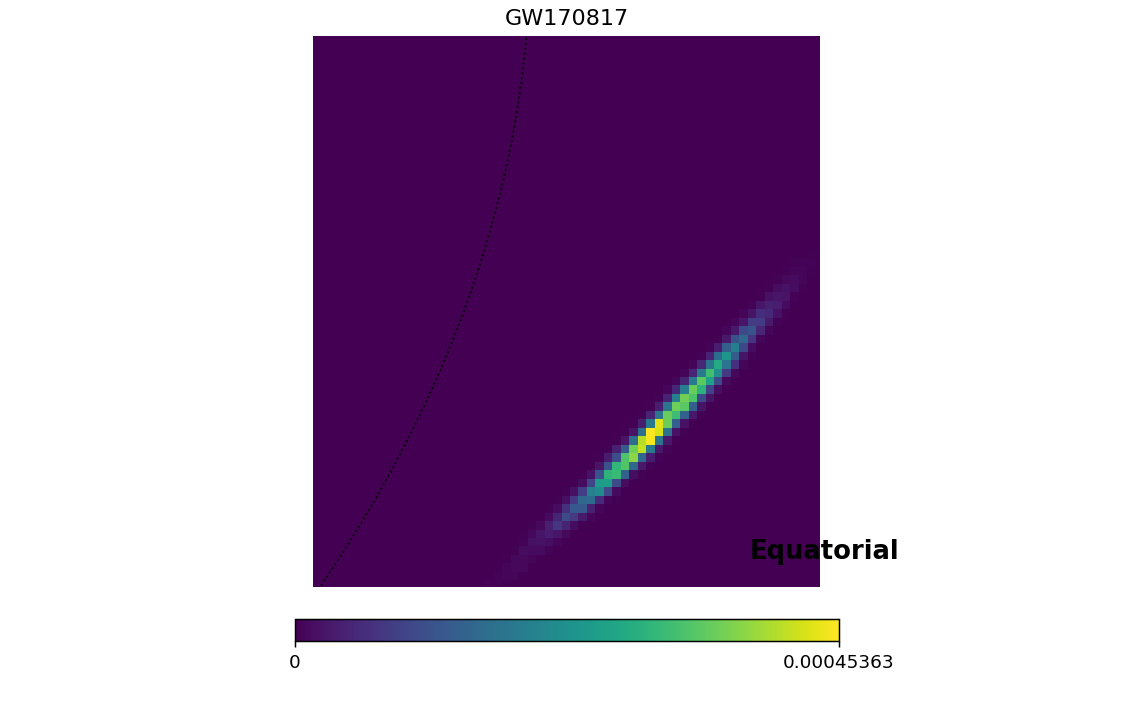

/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/xavier/Projects/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

In [143]:
hp.mollview(
    gw170817,
    coord=["C"],
    title="GW170817",
    #unit="mK",
    #norm="hist",
    #min=-1,
    #max=1,
)
hp.graticule()

## Galaxies
    https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=VII/275

In [37]:
galfile = os.path.join(resource_filename('astropath', 'data'), 'gw_examples', 
                     'GW170817_galaxies.fits.gz')

In [38]:
gw170817_gal = Table.read(galfile).to_pandas()

In [39]:
gw170817_gal.head()

,RAJ2000,DEJ2000,Dist,Bmag,BmagHyp,ImagHyp,modzHyp,mod0Hyp,logd25Hyp,logr25Hyp,...,BmagGWGC,maj,min,PAGWGC,DistGWGC,Kmag2MPZ,Bmag2MPZ,zsp2MPZ,zph2MPZ,Flag
0,159.447266,-27.081240,48.500,12.570000,12.92,10.56,33.099998,NaN,1.42,0.18,...,12.570000,1.286,0.952,8.000000,48.500,NaN,15.184000,NaN,0.037287,1
1,191.318192,2.449015,73.611,16.809999,16.93,16.02,34.439999,NaN,0.50,0.10,...,16.809999,0.316,0.251,164.100006,73.611,NaN,17.573999,NaN,0.100999,1
2,307.511841,-8.717318,62.931,15.010000,15.34,13.76,34.090000,NaN,1.06,0.68,...,15.010000,1.148,0.240,112.300003,62.931,NaN,16.716999,NaN,0.064840,1
3,150.212845,-65.102760,82.500,15.220000,16.40,13.76,34.680000,NaN,0.83,0.10,...,15.220000,0.676,0.537,9.000000,82.500,NaN,16.697001,NaN,0.068866,1
4,198.364731,36.593651,18.793,10.330000,10.70,8.83,31.030001,30.84,1.99,0.33,...,10.330000,7.399,2.812,172.300003,18.793,NaN,14.738000,NaN,0.025601,1


In [144]:
197.4-360.

-162.6

### Cut down

In [55]:
ngc_4993 = SkyCoord('13h09m47.706s -23d23m01.79s', frame='icrs')

In [43]:
gal_coord = SkyCoord(ra=gw170817_gal.RAJ2000, dec=gw170817_gal.DEJ2000, unit='deg')

In [57]:
imin = np.argmin(ngc_4993.separation(gal_coord))
gw170817_gal.iloc[imin]

RAJ2000      197.448776
DEJ2000      -23.383831
Dist          33.806000
Bmag          12.870000
BmagHyp       13.450000
ImagHyp       11.310000
modzHyp       33.130001
mod0Hyp             NaN
logd25Hyp      1.190000
logr25Hyp      0.060000
logdcHyp       1.260000
PAHyp        173.199997
BmagHypC      12.870000
ImagHypC      11.080000
U-BHypC             NaN
B-VHypC             NaN
Jmag2         10.292000
Hmag2          9.599000
Kmag2          9.330000
a_b            0.900000
PAK          -20.000000
BmagGWGC      12.870000
maj            0.932000
min            0.792000
PAGWGC       173.199997
DistGWGC      33.806000
Kmag2MPZ       9.285000
Bmag2MPZ      13.160000
zsp2MPZ        0.009680
zph2MPZ        0.012307
Flag           0.000000
Name: 667145, dtype: float64

In [62]:
imin

667145

In [58]:
np.min(ngc_4993.separation(gal_coord).to('arcmin'))

<Angle 6.96811527e-05 arcmin>

In [119]:
cut_galaxies = gw170817_gal.iloc[667000+np.arange(5000)].copy()

In [120]:
cut_galaxies = cut_galaxies[np.isfinite(cut_galaxies.maj)]

In [121]:
cut_galaxies.head()

,RAJ2000,DEJ2000,Dist,Bmag,BmagHyp,ImagHyp,modzHyp,mod0Hyp,logd25Hyp,logr25Hyp,...,BmagGWGC,maj,min,PAGWGC,DistGWGC,Kmag2MPZ,Bmag2MPZ,zsp2MPZ,zph2MPZ,Flag
667013,357.169220,-2.362345,92.028,15.330000,15.810000,14.02,34.919998,NaN,0.85,0.19,...,15.330000,0.708,0.457,136.199997,92.028,12.761,15.622,0.02219,0.031973,0
667018,150.132019,-31.244976,31.583,12.600000,12.950000,10.66,32.619999,NaN,1.31,0.15,...,12.600000,2.042,1.446,179.899994,31.583,8.792,12.490,0.00813,0.008867,0
667030,76.325119,-9.147248,44.347,12.530000,13.030000,10.86,33.330002,NaN,1.43,0.35,...,12.530000,1.816,0.890,112.000000,44.347,8.818,12.735,0.01090,0.010972,0
667044,338.249908,-20.094194,80.264,14.130000,14.430000,13.35,34.570000,NaN,1.05,0.03,...,14.130000,0.830,0.772,NaN,80.264,12.792,14.575,0.01905,0.011343,0
667076,138.796539,29.252758,88.167,16.190001,17.129999,NaN,34.830002,NaN,0.72,0.46,...,16.190001,0.525,0.182,2.400000,88.167,13.127,16.320,0.02080,0.062994,0


### Coordinates

In [122]:
cut_gal_coord = SkyCoord(ra=cut_galaxies.RAJ2000, dec=cut_galaxies.DEJ2000, unit='deg')

In [137]:
np.min(ngc_4993.separation(cut_gal_coord).to('arcmin'))

<Angle 6.96811527e-05 arcmin>

In [141]:
np.argmin(ngc_4993.separation(cut_gal_coord))

11

In [142]:
cut_galaxies.iloc[11]

RAJ2000      1.974488e+02
DEJ2000     -2.338383e+01
Dist         3.380600e+01
Bmag         1.287000e+01
BmagHyp      1.345000e+01
ImagHyp      1.131000e+01
modzHyp      3.313000e+01
mod0Hyp               NaN
logd25Hyp    1.190000e+00
logr25Hyp    6.000000e-02
logdcHyp     1.260000e+00
PAHyp        1.732000e+02
BmagHypC     1.287000e+01
ImagHypC     1.108000e+01
U-BHypC               NaN
B-VHypC               NaN
Jmag2        1.029200e+01
Hmag2        9.599000e+00
Kmag2        9.330000e+00
a_b          9.000000e-01
PAK         -2.000000e+01
BmagGWGC     1.287000e+01
maj          9.320000e-01
min          7.920000e-01
PAGWGC       1.732000e+02
DistGWGC     3.380600e+01
Kmag2MPZ     9.285000e+00
Bmag2MPZ     1.316000e+01
zsp2MPZ      9.680000e-03
zph2MPZ      1.230700e-02
Flag         0.000000e+00
P_O_raw      5.102511e+07
P_O          6.478168e-03
p_xO         0.000000e+00
P_Ox         0.000000e+00
Name: 667145, dtype: float64

# PATH time

## Priors

In [149]:
offset_prior = dict(method='exp', 
                   max=6., # units of ang_size
                   ang_size=cut_galaxies.maj.values*60., # arcsec
                  )
priors = dict(offset=offset_prior, 
              O='inverse', 
              U=0., 
              name='Adopted')

### Raw

In [150]:
raw_prior_Oi = bayesian.raw_prior_Oi(priors['O'],
                                     cut_galaxies.Bmag.values)
cut_galaxies['P_O_raw'] = raw_prior_Oi

### Normalize

In [151]:
cut_galaxies['P_O'] = bayesian.renorm_priors(cut_galaxies.P_O_raw.values, priors['U'])

## Calculate $p(x|O)$

In [155]:
reload(bayesian)
p_xOi = bayesian.px_Oi_healpix(gw170817, header['NSIDE'], 
                      cut_gal_coord, offset_prior)#, debug=True)

In [156]:
cut_galaxies['p_xO'] = p_xOi

## $p(x)$

In [157]:
p_x = np.sum(cut_galaxies.P_O * cut_galaxies.p_xO)
p_x

0.0003336599134705857

## Posteriors $P(O|x)$

In [158]:
P_Oix = cut_galaxies.P_O * p_xOi / p_x
cut_galaxies['P_Ox'] = P_Oix

In [159]:
cut_galaxies[['RAJ2000', 'DEJ2000', 'Bmag', 'maj', 'P_O', 'p_xO', 'P_Ox']].sort_values('P_Ox', ascending=False)

,RAJ2000,DEJ2000,Bmag,maj,P_O,p_xO,P_Ox
667145,197.448776,-23.383831,12.87,0.932,0.006478,5.150505e-02,9.999953e-01
668837,193.861099,-20.892786,15.73,0.776,0.000128,1.240952e-05,4.744702e-06
667931,194.469193,-22.638481,15.52,1.047,0.000167,5.234014e-09,2.623018e-09
671560,206.735901,-39.884365,14.88,0.757,0.000388,1.849723e-11,2.151224e-11
670857,192.973251,-12.604387,16.27,0.468,0.000064,4.714007e-11,9.103185e-12
...,...,...,...,...,...,...,...
668699,180.701767,21.145529,16.00,0.871,0.000090,0.000000e+00,0.000000e+00
668667,110.026970,53.010151,14.28,0.757,0.000875,0.000000e+00,0.000000e+00
668650,140.950027,2.112878,15.07,0.630,0.000301,0.000000e+00,0.000000e+00
668626,21.381145,32.136272,13.63,1.582,0.002167,0.000000e+00,0.000000e+00


## F'ing A

----

# Multi order
    https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html

In [36]:
mofile = os.path.join(resource_filename('astropath', 'data'), 'gw_examples', 
                     'GW190814_PublicationSamples.multiorder.fits')

----

# Generate a localization
    https://lscsoft.docs.ligo.org/ligo.skymap/index.html

----

In [70]:
SkyCoord(b=23., l=54., frame='galactic', unit='deg')

<SkyCoord (Galactic): (l, b) in deg
    (54., 23.)>

In [145]:
HP = hp.ang2pix(header['NSIDE'], 197., -21., lonlat=True)

In [146]:
HP

8544449

In [147]:
gw170817[HP]

0.00010099744925274434